In [133]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
from IPython.display import Image
from scipy.optimize import curve_fit
from random import randint

In [134]:
df = pd.read_pickle("train.pickle")
unit_converters = pickle.load(open(r'unit_converters.pickle','rb'))

In [135]:
# need the location of vancouver centre in normalized units

from_lat = eval(unit_converters['from_latitude'])
from_long = eval(unit_converters['from_longitude'])

vancouver_centre = [49.2820, 123.1171]
vancouver_centre_norm = [from_lat(vancouver_centre[0]),from_long(vancouver_centre[1])]

I expect that price is going to primarily determined by area and distance from the city centre. I'm going to do some initial plotting to verify that and then fit a simple model to the data

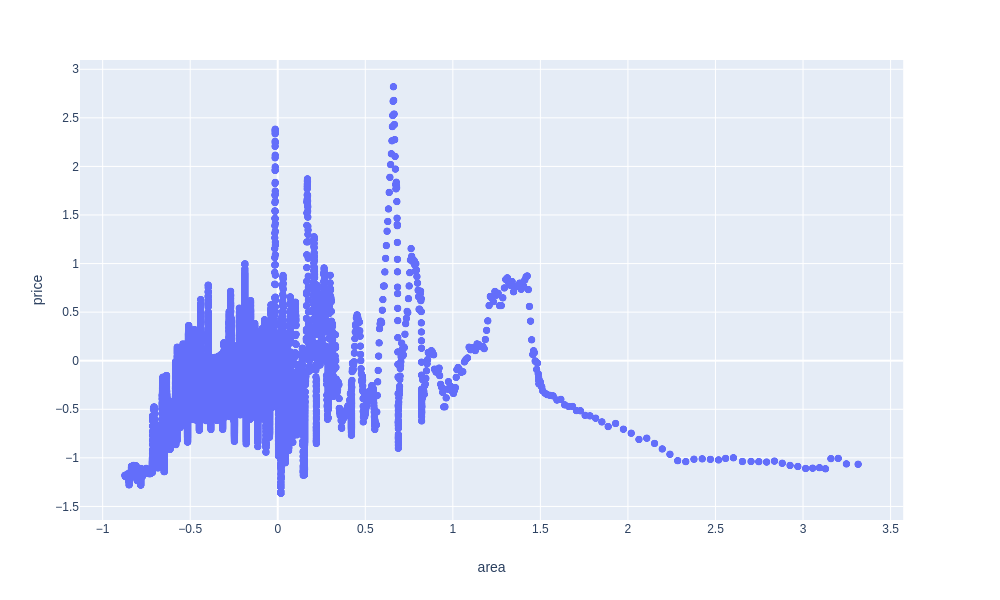

In [136]:
area_df = pd.DataFrame()
area_df['area'] = df[df['1_bed'] == 1]['area']
area_df['price'] = df[df['1_bed'] == 1]['price']
area_df = area_df.sort_values(by=['area'])
area_df = area_df.rolling(30,win_type='boxcar').mean()
area_df = area_df.dropna()
area_df = area_df.reset_index(drop=True)
fig = px.scatter(area_df,x='area',y='price')
Image(fig.to_image(format='png',width=1000))

This looks like logarithmic behaviour, so we'll model it that way.

In [137]:
# fit a log function

# def poly_model (x,a,b,c,d):
#     return b + a*x + c*np.sqrt(x-d)

def log_model (x,a,b,c):
    return a + b*np.log(x-c)

x_data = area_df['price'].to_numpy()

popt, pcov = curve_fit(log_model,area_df['area'].to_numpy(),x_data,p0=[1.0,1.0,-1.0],bounds=([0.0,0.0,-np.inf],[np.inf,np.inf,area_df['area'].min()]))
popt

array([ 3.14052373e-09,  4.41113334e-01, -8.73964819e-01])

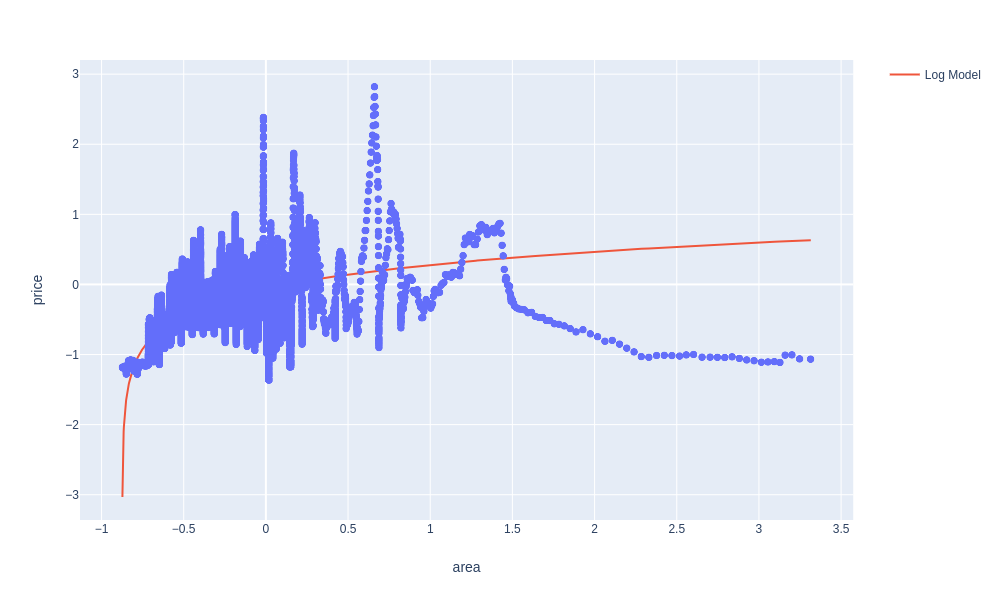

In [138]:
x = area_df['area'].to_numpy()
pred = pd.Series(log_model(x,popt[0],popt[1],popt[2]))
area_df['pred'] = pred
fig = px.scatter(area_df,x='area',y='price')
fig.add_scatter(x=area_df['area'],y=area_df['pred'],name='Log Model')
Image(fig.to_image(format='png',width=1000))

In [139]:
def bespoke_model(x,*p):
    """
    My hand-crafted, artisinal linear model. Uses only a subset of variables.
    - constant term
    - linear term for distance from downtown
    - linear term for furnished/not-furnished
    - linear term for date
    - log term for area
    - log term for number of bedrooms
    """
    date,lat,long,area,bedrooms,furnished = x
    
    # lat longs are not actually a euclidean distance, they are on the surface of a sphere...
    # is it valid to treat them like that?
    # probably a reasonable approximation since this is a very small area
    # would be nice to convert to actual geodesic distance though
    
    downtown_location = vancouver_centre_norm
    distance_from_downtown = np.sqrt((downtown_location[0] - lat)**2 + (downtown_location[1] - long)**2)
    
    
    return p[0] + p[1]*distance_from_downtown + p[2]*furnished + p[3]*date + p[4]*np.log(area-p[5]) + p[6]*np.log(bedrooms-p[7])
    
    

The next step is to fit the bespoke model on the full training set.

Finally, we'll evaluate it's success on the test set to see if it's any good

In [140]:
# first, format the x-data as a matrix

x_df = pd.DataFrame()

def n_bedrooms(row):
    for n,key in zip(range(8),['studio','1_bed','2_bed','3_bed','4_bed','5_bed','6_bed','mansion']):
        if row[key] == 1:
            return n

x_df['date'] = df['date']
x_df['latitude'] = df['latitude']
x_df['longitude'] = df['longitude']
x_df['area'] = df['area']
x_df['bedrooms'] = df.apply(n_bedrooms,axis=1) # i think there is a way to do this more efficiently
x_df['furnished'] = df['furnished']

x_data = x_df.to_numpy().transpose()
y_data = df['price'].to_numpy()

In [141]:
# test that the fit function works

bespoke_model(x_data[:,0],*np.random.rand(8))

1267.6554425989389

In [142]:
lower_bounds = np.full(8,-np.inf)
upper_bounds = np.full(8,np.inf)

# make sure the two log terms are bounded
# largest value must be smaller than the min of the input because log(x-c) <- c cannot be > x

upper_bounds[5] = x_df['area'].min()
upper_bounds[7] = x_df['bedrooms'].min()

initial_guess = np.random.rand(8)
initial_guess[5] = min(upper_bounds[5],initial_guess[5])
initial_guess[7] = min(upper_bounds[7],initial_guess[7])

In [143]:
popt, pcov = curve_fit(bespoke_model,x_data,y_data,p0=initial_guess,bounds=(lower_bounds,upper_bounds))
popt

array([-5.55726802e+02,  3.81723206e-01,  4.84730830e-01,  7.99230959e-02,
        1.61992800e+00, -1.73432699e+00,  3.03122559e-01, -1.04206669e+00])

Fitting of the model was successful, let's see how it peformed!

In [144]:
# calculate some predicted prices:

to_price = eval(unit_converters['to_price'])

# do some spot checks:

print("10 Random Comparisons:\n")
for i in np.random.randint(0,high=len(x_df),size=10):
    real_price = to_price(y_data[i])
    pred_price = to_price(bespoke_model(x_data[:,i],*popt))
    error = real_price-pred_price
    print("Price:${:.0f}, Predicted:${:.0f}, Error:${:.0f}".format(real_price,pred_price,error))
    

pred = bespoke_model(x_data,*popt)

average_error = np.mean(np.abs((to_price(pred) - to_price(y_data))))
median_error = np.median(np.abs((to_price(pred) - to_price(y_data))))

print("Average Error:\n")
print("Mean Error: ${:.0f}".format(average_error))
print("Median Error: ${:.0f}".format(median_error))

10 Random Comparisons:

Price:$1100, Predicted:$1517, Error:$-417
Price:$2350, Predicted:$1733, Error:$617
Price:$4500, Predicted:$3063, Error:$1437
Price:$2300, Predicted:$3312, Error:$-1012
Price:$2350, Predicted:$2368, Error:$-18
Price:$1800, Predicted:$1618, Error:$182
Price:$1600, Predicted:$1539, Error:$61
Price:$1950, Predicted:$2132, Error:$-182
Price:$5000, Predicted:$4244, Error:$756
Price:$1500, Predicted:$2107, Error:$-607
Average Error:

Mean Error: $488
Median Error: $361


Overall, not too great. Hopefully the ML models can beat this easily